In [2]:
!curl -O https://lazyprogrammer.me/course_files/timeseries/temperature.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  6 3980k    6  254k    0     0   110k      0  0:00:36  0:00:02  0:00:34  110k
100 3980k  100 3980k    0     0  1558k      0  0:00:02  0:00:02 --:--:-- 1558k


### VARMA

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('temperature.csv')
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


In [4]:
def parse_date(row):
    s = f"{row['year']}-{row['month']}-{row['day']}"
    return datetime.strptime(s, "%Y-%m-%d")

In [5]:
df['Date'] = df.apply(parse_date, axis=1)

In [6]:
auckland = df[df['City'] == 'Auckland'].copy().dropna()
stockholm = df[df['City'] == 'Stockholm'].copy().dropna()

In [7]:
auckland = auckland[['Date', 'AverageTemperatureFahr']].copy()
stockholm = stockholm[['Date', 'AverageTemperatureFahr']].copy()

In [8]:
# set index to date col
auckland.set_index(auckland['Date'], inplace=True)
auckland.drop('Date', axis=1, inplace=True)
auckland.columns = ['AucklandTemp']
auckland.head()

,AucklandTemp
Date,
1853-06-01,51.9062
1853-07-01,52.3886
1853-08-01,52.8530
1853-09-01,52.5776
1853-10-01,54.8726


In [9]:
stockholm.set_index(stockholm['Date'], inplace=True)
stockholm.drop('Date', axis=1, inplace=True)
stockholm.columns = ['StockholmTemp']
stockholm.head()

,StockholmTemp
Date,
1743-11-01,42.8414
1744-04-01,36.8888
1744-05-01,45.1220
1744-06-01,53.1824
1744-07-01,60.0260


In [10]:
joined = auckland.join(stockholm, how='outer')
joined.shape

(3155, 2)

In [11]:
joined_part = joined.iloc[-500:].copy()
joined_part.index.freq = 'MS'
joined_part.isna().sum()


AucklandTemp     1
StockholmTemp    4
dtype: int64

In [12]:
joined_part.interpolate(inplace=True)
joined_part.isna().sum()

AucklandTemp     0
StockholmTemp    0
dtype: int64

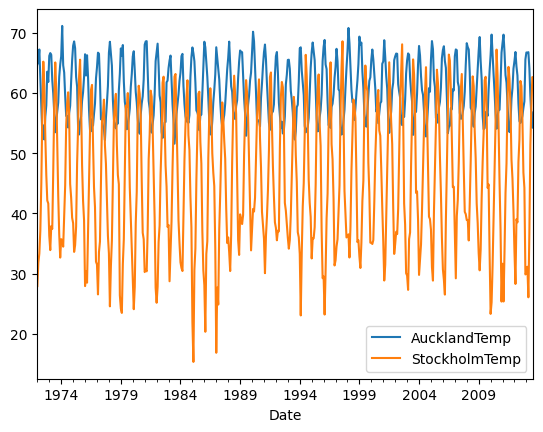

In [13]:
joined_part.plot();

In [16]:
Ntest = 12
train = joined_part.iloc[:-Ntest].copy()
test = joined_part.iloc[-Ntest:].copy()

In [17]:
# Scale the data
scaler_auckland = StandardScaler()
train['ScaledAuckland'] = scaler_auckland.fit_transform(
    train[['AucklandTemp']])
test['ScaledAuckland'] = scaler_auckland.transform(test[['AucklandTemp']])

In [18]:
scaler_stockholm = StandardScaler()
train['ScaledStockholm'] = scaler_stockholm.fit_transform(
    train[['StockholmTemp']])
test['ScaledStockholm'] = scaler_stockholm.transform(test[['StockholmTemp']])

In [19]:
train_idx = joined_part.index <= train.index[-1]
test_idx = joined_part.index > train.index[-1]

In [20]:
joined_part.loc[train_idx, 'ScaledAuckland'] = train['ScaledAuckland']
joined_part.loc[test_idx, 'ScaledAuckland'] = test['ScaledAuckland']
joined_part.loc[train_idx, 'ScaledStockholm'] = train['ScaledStockholm']
joined_part.loc[test_idx, 'ScaledStockholm'] = test['ScaledStockholm']

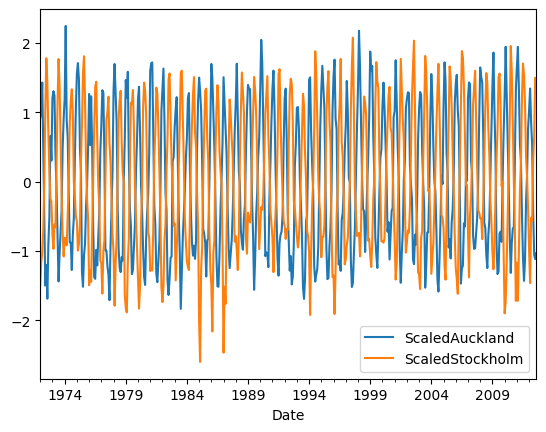

In [21]:
cols = ['ScaledAuckland', 'ScaledStockholm']
train[cols].plot();

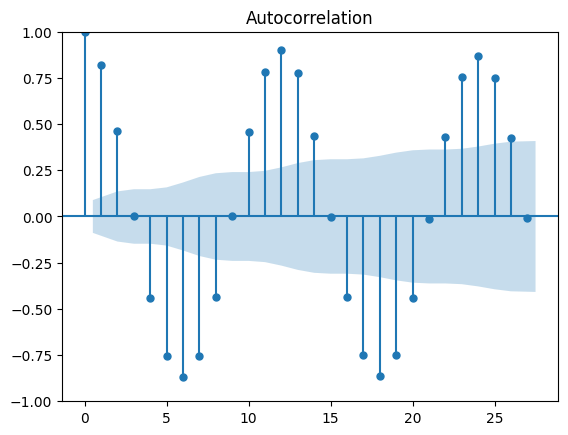

In [22]:
plot_acf(train['ScaledAuckland']);

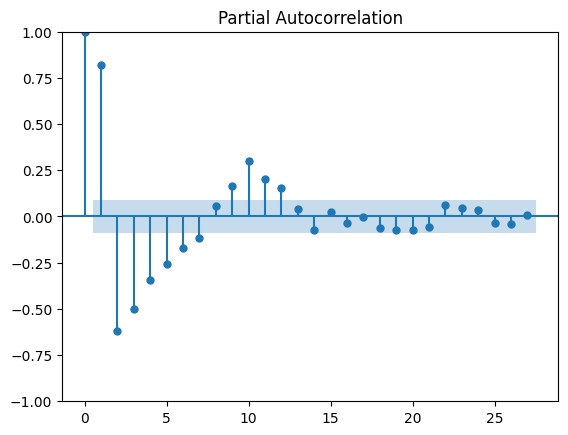

In [23]:
plot_pacf(train['ScaledAuckland']);

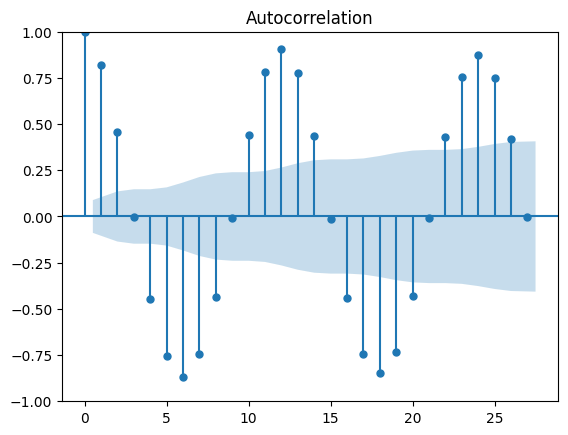

In [24]:
plot_acf(train['ScaledStockholm']);

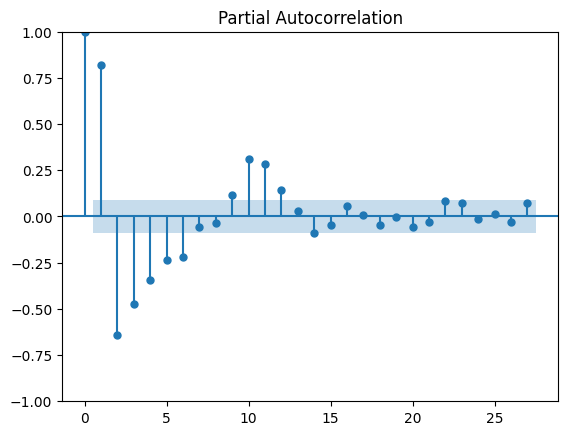

In [25]:
plot_pacf(train['ScaledStockholm']);

In [26]:
# Fit the model
t0 = datetime.now()
model = VARMAX(train[cols], order=(10, 10))
res = model.fit(maxiter=100)
print("Duration:", datetime.now() - t0)

c:\aconda\envs\time_series_env\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\aconda\envs\time_series_env\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
c:\aconda\envs\time_series_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:16:49.689201


In [28]:
fcast = res.get_forecast(Ntest)
confint = fcast.conf_int()

,lower ScaledAuckland,lower ScaledStockholm,upper ScaledAuckland,upper ScaledStockholm
2012-09-01,-1.416942,0.355397,-0.401935,1.390800
2012-10-01,-1.097976,-0.183665,-0.033937,0.916433
2012-11-01,-0.418544,-0.871856,0.655948,0.237075
2012-12-01,0.233075,-1.367388,1.314589,-0.256447
2013-01-01,0.843869,-1.790168,1.932621,-0.676980
2013-02-01,0.860194,-1.745170,1.953687,-0.629832
2013-03-01,0.624138,-1.541544,1.720063,-0.424633
2013-04-01,-0.171717,-1.003267,0.924536,0.120684
2013-05-01,-0.837953,-0.294873,0.261327,0.833210
2013-06-01,-1.428820,0.475824,-0.326667,1.605180


In [31]:
res.fittedvalues['ScaledAuckland']
joined_part.loc[train_idx, 'Train Pred Auckland'] = \
  res.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = \
  fcast.predicted_mean['ScaledAuckland']
joined_part.loc[test_idx, 'lower Auckland'] = \
  confint['lower ScaledAuckland']
joined_part.loc[test_idx, 'upper Auckland'] = \
  confint['upper ScaledAuckland']

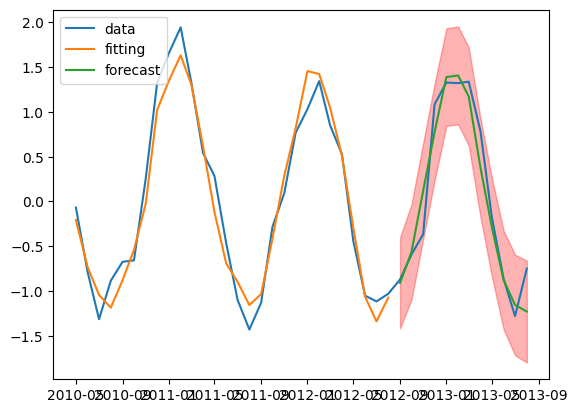

In [40]:
plot_cols = ['ScaledAuckland', 'Train Pred Auckland', 'Test Pred Auckland']
labels = ['data', 'fitting', 'forecast']
fig, ax = plt.subplots()
for i in range(len(labels)):
    ax.plot(joined_part.iloc[-40:][plot_cols[i]], label=labels[i]);
ax.fill_between(test.index, confint['lower ScaledAuckland'], confint['upper ScaledAuckland'], color='red', alpha=0.3)
ax.legend();

In [41]:
res.fittedvalues['ScaledStockholm']
joined_part.loc[train_idx, 'Train Pred Stockholm'] = \
  res.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = \
  fcast.predicted_mean['ScaledStockholm']
joined_part.loc[test_idx, 'lower Stockholm'] = \
  confint['lower ScaledStockholm']
joined_part.loc[test_idx, 'upper Stockholm'] = \
  confint['upper ScaledStockholm']

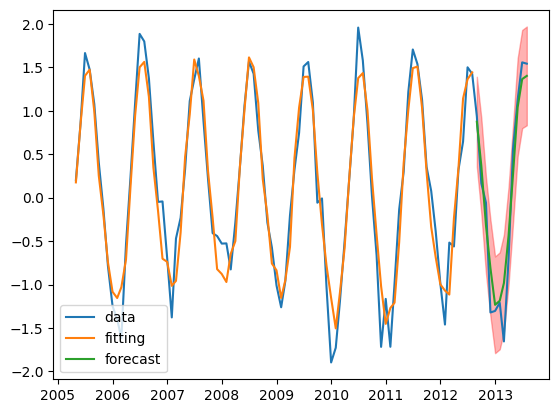

In [43]:
plot_cols = ['ScaledStockholm', 'Train Pred Stockholm', 'Test Pred Stockholm']
labels = ['data', 'fitting', 'forecast']
fig, ax = plt.subplots()
for i in range(len(labels)):
    ax.plot(joined_part.iloc[-100:][plot_cols[i]], label=labels[i]);
ax.fill_between(test.index, confint['lower ScaledStockholm'], confint['upper ScaledStockholm'], color='red', alpha=0.3)
ax.legend();

In [44]:
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']
print("Auckland Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']
y_true = joined_part.loc[test_idx, 'ScaledAuckland']
print("Auckland Test R^2:", r2_score(y_true, y_pred))

Auckland Train R^2: 0.9294276323500341
Auckland Test R^2: 0.9293679065796734


In [45]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']
print("Stockholm Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Stockholm']
y_true = joined_part.loc[test_idx, 'ScaledStockholm']
print("Stockholm Test R^2:", r2_score(y_true, y_pred))

Stockholm Train R^2: 0.924719846301581
Stockholm Test R^2: 0.9317705694370984


### VAR

In [46]:
model = VAR(train[cols])
lag_order_results = model.select_order(maxlags=15)
lag_order_results

In [47]:
lag_order_results.selected_orders

{'aic': 12, 'bic': 6, 'hqic': 11, 'fpe': 12}

In [48]:
results = model.fit(maxlags=15, ic='aic')

In [51]:
lag_order = results.k_ar
lag_order

12

In [54]:
prior = train.iloc[-lag_order:][cols].to_numpy()
fcast = results.forecast(prior, Ntest)

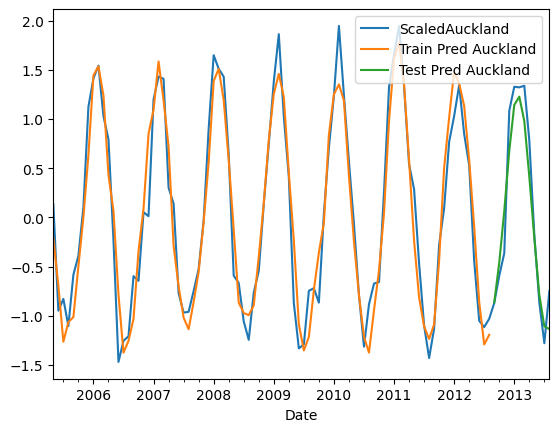

In [55]:
joined_part.loc[train_idx, 'Train Pred Auckland'] = \
  results.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = \
  fcast[:,0]

plot_cols = ['ScaledAuckland', 'Train Pred Auckland', 'Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot();

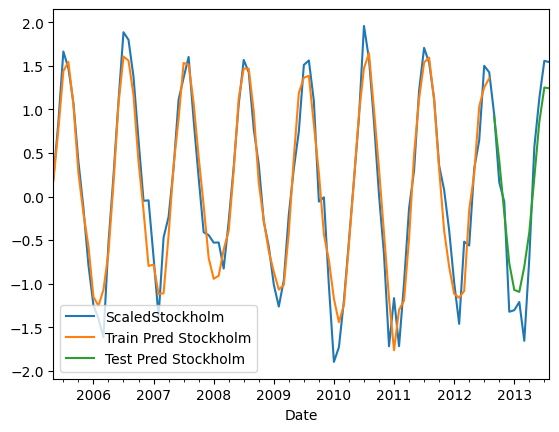

In [57]:
joined_part.loc[train_idx, 'Train Pred Stockholm'] = \
  results.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = \
  fcast[:,1]

plot_cols = ['ScaledStockholm', 'Train Pred Stockholm', 'Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot();

In [58]:
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("Auckland Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']
y_true = joined_part.loc[test_idx, 'ScaledAuckland']
print("Auckland Test R^2:", r2_score(y_true, y_pred))

Auckland Train R^2: 0.921070700106029
Auckland Test R^2: 0.9233643831340894


In [59]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("Stockholm Train R^2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, 'Test Pred Stockholm']
y_true = joined_part.loc[test_idx, 'ScaledStockholm']
print("Stockholm Test R^2:", r2_score(y_true, y_pred))

Stockholm Train R^2: 0.9267030553588321
Stockholm Test R^2: 0.8930437688204874


### Comparing to ARIMA baseline

In [60]:
from statsmodels.tsa.arima.model import ARIMA
for col in cols:
  model = ARIMA(train[col], order=(10, 0, 10))
  res = model.fit()
  fcast = res.get_forecast(Ntest)
  print(f"{col} Train R^2:", r2_score(joined_part.loc[train_idx, col], res.fittedvalues))
  print(f"{col} Test R^2:", r2_score(joined_part.loc[test_idx, col], fcast.predicted_mean))

c:\aconda\envs\time_series_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ScaledAuckland Train R^2: 0.9213763792674496
ScaledAuckland Test R^2: 0.9380752420824932
ScaledStockholm Train R^2: 0.9207424517419222
ScaledStockholm Test R^2: 0.9485360625472288


c:\aconda\envs\time_series_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
